In [1]:
import sys
import os

sys.path.append(os.path.abspath('/home/yz/gitProject_linux'))
from Point_Cloud_Registration.utilities import  *
import pyrealsense2 as rs
import numpy as np
import cv2
from utilites import *
import apriltag
import matplotlib.pyplot as plt
from D435i import D435i

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
myD435i = D435i(families='tag36h11')

In [4]:
myD435i.stop_pipline()

In [3]:
myD435i = D435i(families='tag36h11')
tag_point = np.array([[0,0,0],[-1, 1, 0],[1,1,0],[1,-1,0]])

while True:
    depth_image, color_image = myD435i.get_image()
    gray_img = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
    tags = myD435i.get_tags(gray_img)
    color_image = draw_tags_box(tags, color_image)
    for tag in tags:
        # real_center = myD435i.get_3d_coordinates(depth_image, tag.center)
        # print(real_center)
        
        h = np.zeros((4,4))
        real_center = myD435i.get_3d_coordinates(depth_image, tag.center)
        h[0:3,0:3] = tag.homography
        print(h)
       
        

    cv2.imshow('RealSense Color', color_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
myD435i.stop_pipline()
cv2.destroyAllWindows()
    

[[ 6.18390150e-01 -8.21723618e-02  5.18920059e+00  0.00000000e+00]
 [-1.34037134e-01  5.58645068e-01  2.92458605e+00  0.00000000e+00]
 [-1.96468069e-04 -3.83041316e-04  9.74650706e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[-6.28130913e-01  8.41077949e-02 -5.10435779e+00  0.00000000e+00]
 [ 1.19308711e-01 -5.65436477e-01 -2.93479406e+00  0.00000000e+00]
 [ 1.85784374e-04  3.63448010e-04 -9.74007323e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 6.32482145e-01 -1.06699387e-01  4.94970695e+00  0.00000000e+00]
 [-1.03440551e-01  5.57450633e-01  2.87660587e+00  0.00000000e+00]
 [-1.89401730e-04 -3.93990676e-04  9.71794413e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
True
[[-6.24711023e-01  1.57352198e-01 -5.09078265e+00  0.00000000e+00]
 [ 2.97779524e-02 -5.92231913e-01 -2.54190541e+00  0.00000000e+00]
 [ 2.04253603e-04  3.40544419e-04 -9.82663547e-03  0.0

In [31]:
h = np.zeros((4,4))

In [9]:
print(tags)
print(tags[0].corners[0])
np.linalg.inv(tags[0].homography) @ np.concatenate((tags[0].corners[0],[1]))

[Detection(tag_family=b'tag36h11', tag_id=0, hamming=0, goodness=0.0, decision_margin=60.37083435058594, homography=array([[-6.96763390e-01,  1.24965401e-01, -4.91320001e+00],
       [ 3.13330970e-02, -5.90125539e-01, -2.86107062e+00],
       [ 7.02274113e-05,  3.75771288e-04, -1.14196684e-02]]), center=array([430.240163 , 250.5388521]), corners=array([[365.87930298, 194.02854919],
       [489.11087036, 191.00822449],
       [499.83261108, 311.64260864],
       [368.13256836, 313.34265137]]))]
[365.87930298 194.02854919]


array([ 84.27676152,  84.27676152, -84.27676152])

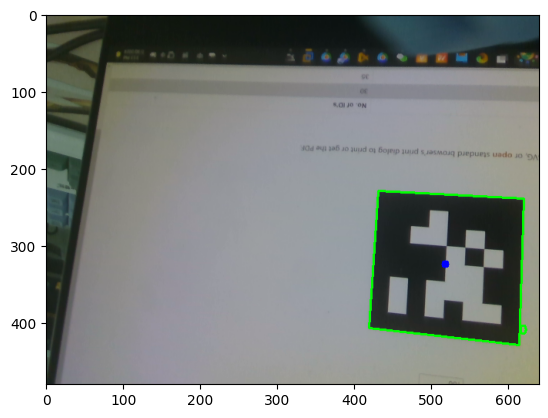

In [23]:
plt.imshow(color_image)

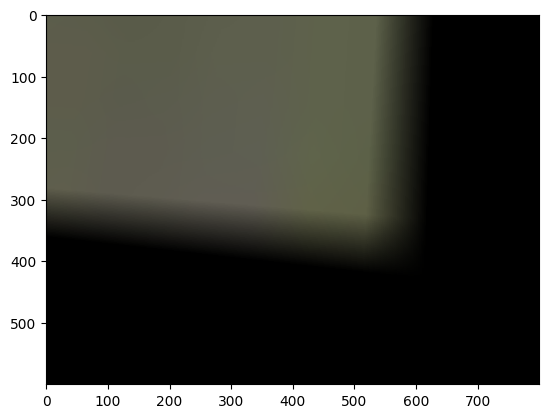

In [27]:

output_size = (800, 600)
warped_image = cv2.warpPerspective(color_image, tags[0].homography,output_size)
plt.imshow(warped_image)

In [25]:
real_point = []
for corner in tags[0].corners:
    print(corner)
    real_corner = myD435i.get_3d_coordinates(depth_image, corner)
    real_point.append(real_corner)
    # modified_corner = np.concatenate((a, np.zeros((4,1))), axis = 1)
tag_point = np.array([[-1, 1, 0],[1,1,0],[-1,-1,0],[1,-1,0]])
real_point
    

[532.05755615 320.25393677]
[358.44284058 318.66824341]
[347.01385498 154.13705444]
[533.61914063 143.21458435]


[[], [], array([inf, inf, 0.2]), array([  inf,   inf, 0.183])]

In [31]:
tags[0].corners

array([[287.09695435, 217.00518799],
       [449.47009277, 201.66217041],
       [475.88861084, 367.35339355],
       [305.55978394, 387.34902954]])

In [32]:
real_center = myD435i.get_3d_coordinates(depth_image, tags[0].center)
real_center

array([  inf,   inf, 0.216])

In [21]:
c = np.concatenate((a, np.zeros((4,1))), axis = 1)
c.shape

(4, 3)

In [70]:
myD435i = D435i(families='tag36h11')
depth_image, color_image = myD435i.get_image()
pld = myD435i.depth_to_point_cloud(depth_image, threshold=500)
myD435i.stop_pipline()

In [61]:

pcd_cloud = []

In [71]:
import open3d as o3d
print(len(pld))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pld)
voxel_size = 0.005
pcd = pcd.voxel_down_sample(voxel_size)
o3d.visualization.draw_geometries([pcd])

105117


In [72]:
pcd_cloud.append(pcd)

In [73]:
len(pcd_cloud)

4

In [77]:
base_cloud = pcd_cloud[0]

In [84]:
for i, pcd in enumerate(pcd_cloud):
    filename = f"point_cloud_{i+1}.ply"
    o3d.io.write_point_cloud(filename, pcd)
    print(f"点云数据已保存到 {filename}")

点云数据已保存到 point_cloud_1.ply
点云数据已保存到 point_cloud_2.ply
点云数据已保存到 point_cloud_3.ply
点云数据已保存到 point_cloud_4.ply


In [78]:
o3d.visualization.draw_geometries([base_cloud])

In [76]:
for pcd in pcd_cloud[1:]:
    base_cloud,_ = base_cloud.remove_radius_outlier(nb_points=15, radius=0.006)
    pcd,_ = pcd.remove_radius_outlier(nb_points=15, radius=0.006)
    # target_down, target_fpfh = preprocess_point_cloud(base_cloud, voxel_size)
    # source_down, source_fpfh = preprocess_point_cloud(pcd, voxel_size)
    # result = execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)
    # trans = result.transformation
    # pcd.transform(trans)
    # reg = icpRegistration(source_down, target_down, threshold= 0.00005, iteration=5000)
    # print(reg.fitness)
    # trans = reg.transformation
    # pcd.transform(trans)
    # base_cloud = base_cloud + pcd

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


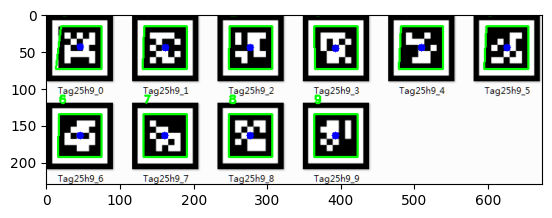

In [4]:
frame = cv2.imread('apriltag.png')
detect = detector(families='tag25h9')
gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
tags = get_tags(detect, gray_img)
frame = draw_tags_box(tags, frame)
plt.imshow(frame)

In [10]:
# pipeline.start(config)
frames = pipeline.wait_for_frames()
depth_frame = frames.get_depth_frame()
depth_image = np.asanyarray(depth_frame.get_data())
print(depth_image.shape)

(480, 640)


In [14]:
homography=np.array([[-5.63883522e-01, -4.47734408e-01, -1.93054772e+00],
                     [ 4.35035775e-01, -4.32272755e-01, -2.45711029e+00],
                     [-2.28876529e-04,  1.71351888e-04, -7.36692500e-03]])

In [7]:
tags

[Detection(tag_family=b'tag36h11', tag_id=1, hamming=0, goodness=0.0, decision_margin=65.88518524169922, homography=array([[-6.66065073e-01, -1.57823661e-01,  4.20335003e+00],
        [ 8.41265571e-02, -7.65526230e-01,  2.85069092e+00],
        [ 1.55650348e-04, -2.96972623e-04,  8.88967494e-03]]), center=array([472.8350652, 320.6743706]), corners=array([[556.66485596, 391.10748291],
        [395.52459717, 396.08496094],
        [386.296875  , 247.96568298],
        [558.44049072, 237.17266846]]))]

In [11]:
tag = tags[0]

In [15]:
corners = tag.corners
a = corners.sum(axis = 0)
b = a / 4
print(b)

[474.23170471 318.08269882]
